In [5]:
# client_Alzheimers.py
import flwr as fl
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.validation import check_is_fitted

# -----------------------------
# CLIENT CONFIG
# -----------------------------
client_name = "Alzheimer's"
dataset_path = r"D:\DAML\ML\datasets neuro\alzheimers_disease_data.csv"
target_column = "Diagnosis"
server_address = "10.244.107.149:5555"

# -----------------------------
# LOAD DATA
# -----------------------------
df = pd.read_csv(dataset_path)
X = df.drop(columns=[target_column])
y = df[target_column]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -----------------------------
# PREPROCESSING
# -----------------------------
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=["int64", "float64"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# -----------------------------
# FLOWER CLIENT
# -----------------------------
class AlzheimersClient(fl.client.NumPyClient):
    def __init__(self):
        self.model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
        self.X_train = X_train_processed
        self.y_train = np.array(y_train)
        self.X_test = X_test_processed
        self.y_test = np.array(y_test)

    def get_parameters(self, config):
        # Tree-based models: just return empty list to avoid NotFittedError
        return []

    def fit(self, parameters, config):
        self.model.fit(self.X_train, self.y_train)
        accuracy = self.model.score(self.X_train, self.y_train)
        return [], len(self.X_train), {"accuracy": float(accuracy), "client_name": client_name}

    def evaluate(self, parameters, config):
        # Check if model is fitted before scoring
        try:
            check_is_fitted(self.model)
            accuracy = self.model.score(self.X_test, self.y_test)
        except:
            accuracy = 0.0  # model not fitted yet
        return 0.0, len(self.X_test), {"accuracy": float(accuracy), "client_name": client_name}

# -----------------------------
# START CLIENT
# -----------------------------
if __name__ == "__main__":
    print(f"Connecting to Flower server at {server_address}...")
    fl.client.start_client(
        server_address=server_address,
        client=AlzheimersClient().to_client()  # convert NumPyClient to Client
    )


	Instead, use the `flower-supernode` CLI command to start a SuperNode as shown below:

		$ flower-supernode --insecure --superlink='<IP>:<PORT>'

	To view all available options, run:

		$ flower-supernode --help

	Using `start_client()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      
INFO :      Received: train message 0942a285-8ed1-460e-8c96-d8ae74eb9738


Connecting to Flower server at 10.244.107.149:5555...


INFO :      Sent reply


_MultiThreadedRendezvous: <_MultiThreadedRendezvous of RPC that terminated with:
	status = StatusCode.UNAVAILABLE
	details = "IOCP/Socket: Connection reset (An existing connection was forcibly closed by the remote host.
 -- 10054)"
	debug_error_string = "UNKNOWN:Error received from peer ipv4:10.244.107.149:5555 {grpc_message:"IOCP/Socket: Connection reset (An existing connection was forcibly closed by the remote host.\r\n -- 10054)", grpc_status:14}"
>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import optuna
import joblib
import warnings

warnings.filterwarnings('ignore')

# ======================== CONFIGURATION ========================
FILE_PATH = r"D:\ML\Neurodivergent\Minsk2020_ALS_dataset.csv"
OUTPUT_DIR = r"D:\ML\Neurodivergent"
TEST_SIZE = 0.2
RANDOM_STATE = 42
N_TRIALS = 100
CV_FOLDS = 5

# ======================== LOAD DATA ========================
print("="*70)
print("LOADING DATA")
print("="*70)

df = pd.read_csv(FILE_PATH)
print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"\nFirst 5 rows:\n{df.head()}")
print(f"\nMissing values:\n{df.isnull().sum()[df.isnull().sum() > 0]}")

# ======================== IDENTIFY TARGET ========================
print("\n" + "="*70)
print("IDENTIFYING TARGET")
print("="*70)

# Try common target column names
possible_targets = ['target', 'Target', 'diagnosis', 'Diagnosis', 'class', 
                   'Class', 'label', 'Label', 'ALS', 'als']

target_col = None
for col in possible_targets:
    if col in df.columns:
        target_col = col
        break

if target_col is None:
    target_col = df.columns[-1]

print(f"Target column: '{target_col}'")
print(f"Target distribution:\n{df[target_col].value_counts()}")

# ======================== PREPROCESS DATA ========================
print("\n" + "="*70)
print("PREPROCESSING DATA")
print("="*70)

# Separate features and target
X = df.drop(columns=[target_col])
y = df[target_col]

# Encode categorical features
label_encoders = {}
for col in X.columns:
    if X[col].dtype == 'object':
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le
        print(f"Encoded: {col}")

# Encode target if categorical
le_target = None
if y.dtype == 'object':
    le_target = LabelEncoder()
    y = le_target.fit_transform(y)
    print(f"Target classes: {le_target.classes_}")

# Handle missing values
if X.isnull().sum().sum() > 0:
    X = X.fillna(X.median(numeric_only=True))
    for col in X.columns:
        if X[col].isnull().sum() > 0:
            X[col] = X[col].fillna(X[col].mode()[0])
    print("Missing values handled")

# Determine problem type
n_classes = len(np.unique(y))
is_binary = n_classes == 2
print(f"Problem type: {'Binary' if is_binary else 'Multiclass'} ({n_classes} classes)")

# ======================== SPLIT DATA ========================
print("\n" + "="*70)
print("SPLITTING DATA")
print("="*70)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

print(f"Training: {X_train.shape[0]} samples")
print(f"Test: {X_test.shape[0]} samples")

# ======================== OPTIMIZE HYPERPARAMETERS ========================
print("\n" + "="*70)
print("OPTIMIZING HYPERPARAMETERS")
print("="*70)

def objective(trial):
    """Optuna objective function"""
    params = {
        'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'eta': trial.suggest_float('eta', 0.01, 0.3, log=True),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'tree_method': 'hist',
        'random_state': RANDOM_STATE,
    }
    
    if is_binary:
        params['objective'] = 'binary:logistic'
    else:
        params['objective'] = 'multi:softmax'
        params['num_class'] = n_classes
    
    model = xgb.XGBClassifier(**params)
    skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    scoring = 'f1_weighted' if n_classes > 2 else 'f1'
    cv_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring=scoring, n_jobs=1)
    
    return cv_scores.mean()

# Run optimization
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

print(f"\nBest CV F1 Score: {study.best_trial.value:.4f}")
print("\nBest hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# ======================== TRAIN FINAL MODEL ========================
print("\n" + "="*70)
print("TRAINING FINAL MODEL")
print("="*70)

best_params = study.best_params.copy()
best_params['tree_method'] = 'hist'
best_params['random_state'] = RANDOM_STATE

if is_binary:
    best_params['objective'] = 'binary:logistic'
else:
    best_params['objective'] = 'multi:softmax'
    best_params['num_class'] = n_classes

best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train, y_train)
print("Model trained successfully")

# ======================== EVALUATE MODEL ========================
print("\n" + "="*70)
print("MODEL EVALUATION")
print("="*70)

# Predictions
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Get class names
target_names = le_target.classes_ if le_target else [f"Class {i}" for i in range(n_classes)]

# Training metrics
train_acc = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred, average='weighted' if n_classes > 2 else 'binary')

# Test metrics
test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted' if n_classes > 2 else 'binary')

print("\n--- TRAINING SET ---")
print(f"Accuracy: {train_acc:.4f}")
print(f"F1 Score: {train_f1:.4f}")

print("\n--- TEST SET ---")
print(f"Accuracy: {test_acc:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Classification reports
print("\n" + "-"*70)
print("CLASSIFICATION REPORT - TRAINING SET")
print("-"*70)
print(classification_report(y_train, y_train_pred, target_names=target_names))

print("\n" + "-"*70)
print("CLASSIFICATION REPORT - TEST SET")
print("-"*70)
print(classification_report(y_test, y_test_pred, target_names=target_names))

# Confusion matrices
print("\n" + "-"*70)
print("CONFUSION MATRIX - TRAINING SET")
print("-"*70)
print(confusion_matrix(y_train, y_train_pred))

print("\n" + "-"*70)
print("CONFUSION MATRIX - TEST SET")
print("-"*70)
print(confusion_matrix(y_test, y_test_pred))

# ======================== FEATURE IMPORTANCE ========================
print("\n" + "="*70)
print("FEATURE IMPORTANCE")
print("="*70)

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 features:")
print(feature_importance.head(15).to_string(index=False))

# ======================== SAVE RESULTS ========================
print("\n" + "="*70)
print("SAVING RESULTS")
print("="*70)

# Save model
model_path = f"{OUTPUT_DIR}/best_xgboost_als_model.pkl"
joblib.dump(best_model, model_path)
print(f"Model saved: {model_path}")

# Save encoders
encoders_path = f"{OUTPUT_DIR}/label_encoders_als.pkl"
joblib.dump({
    'feature_encoders': label_encoders,
    'target_encoder': le_target,
    'feature_names': X.columns.tolist()
}, encoders_path)
print(f"Encoders saved: {encoders_path}")

# Save feature importance
importance_path = f"{OUTPUT_DIR}/feature_importance_als.csv"
feature_importance.to_csv(importance_path, index=False)
print(f"Feature importance saved: {importance_path}")

# Save visualizations
try:
    from optuna.visualization import plot_optimization_history, plot_param_importances
    
    fig1 = plot_optimization_history(study)
    fig1.write_html(f"{OUTPUT_DIR}/optimization_history.html")
    
    fig2 = plot_param_importances(study)
    fig2.write_html(f"{OUTPUT_DIR}/param_importances.html")
    
    print("Visualizations saved")
except Exception as e:
    print(f"Could not save visualizations: {e}")

# ======================== FINAL SUMMARY ========================
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)
print(f"Best CV F1 Score: {study.best_trial.value:.4f}")
print(f"Test Accuracy:    {test_acc:.4f}")
print(f"Test F1 Score:    {test_f1:.4f}")
print(f"Overfitting Gap:  {train_f1 - test_f1:.4f}")
print("="*70)

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import optuna
import joblib
import warnings

warnings.filterwarnings('ignore')

# ======================== CONFIGURATION ========================
FILE_PATH = r"D:\ML\Neurodivergent\Minsk2020_ALS_dataset.csv"
OUTPUT_DIR = r"D:\ML\Neurodivergent"
TEST_SIZE = 0.2
RANDOM_STATE = 42
N_TRIALS = 50
CV_FOLDS = 5  # Increased back to 5 for better generalization estimate

# ======================== LOAD DATA ========================
print("="*70)
print("LOADING DATA")
print("="*70)

df = pd.read_csv(FILE_PATH)
print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"\nFirst 5 rows:\n{df.head()}")
print(f"\nMissing values:\n{df.isnull().sum()[df.isnull().sum() > 0]}")

# ======================== IDENTIFY TARGET ========================
print("\n" + "="*70)
print("IDENTIFYING TARGET")
print("="*70)

# Try common target column names
possible_targets = ['target', 'Target', 'diagnosis', 'Diagnosis', 'class', 
                   'Class', 'label', 'Label', 'ALS', 'als']

target_col = None
for col in possible_targets:
    if col in df.columns:
        target_col = col
        break

if target_col is None:
    target_col = df.columns[-1]

print(f"Target column: '{target_col}'")
print(f"Target distribution:\n{df[target_col].value_counts()}")

# ======================== PREPROCESS DATA ========================
print("\n" + "="*70)
print("PREPROCESSING DATA")
print("="*70)

# Separate features and target
X = df.drop(columns=[target_col])
y = df[target_col]

# Encode categorical features
label_encoders = {}
for col in X.columns:
    if X[col].dtype == 'object':
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le
        print(f"Encoded: {col}")

# Encode target if categorical
le_target = None
if y.dtype == 'object':
    le_target = LabelEncoder()
    y = le_target.fit_transform(y)
    print(f"Target classes: {le_target.classes_}")

# Handle missing values
if X.isnull().sum().sum() > 0:
    X = X.fillna(X.median(numeric_only=True))
    for col in X.columns:
        if X[col].isnull().sum() > 0:
            X[col] = X[col].fillna(X[col].mode()[0])
    print("Missing values handled")

# Determine problem type
n_classes = len(np.unique(y))
is_binary = n_classes == 2
print(f"Problem type: {'Binary' if is_binary else 'Multiclass'} ({n_classes} classes)")

# ======================== SPLIT DATA ========================
print("\n" + "="*70)
print("SPLITTING DATA")
print("="*70)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

print(f"Training: {X_train.shape[0]} samples")
print(f"Test: {X_test.shape[0]} samples")

# ======================== OPTIMIZE HYPERPARAMETERS ========================
print("\n" + "="*70)
print("OPTIMIZING HYPERPARAMETERS")
print("="*70)

def objective(trial):
    """Optuna objective function with strong regularization"""
    params = {
        'booster': 'gbtree',
        'lambda': trial.suggest_float('lambda', 1.0, 100.0, log=True),  # Stronger L2
        'alpha': trial.suggest_float('alpha', 1.0, 50.0, log=True),  # Stronger L1
        'max_depth': trial.suggest_int('max_depth', 2, 5),  # Shallower trees
        'eta': trial.suggest_float('eta', 0.01, 0.1),  # Lower learning rate
        'gamma': trial.suggest_float('gamma', 1.0, 10.0),  # Higher min split loss
        'subsample': trial.suggest_float('subsample', 0.5, 0.8),  # More aggressive sampling
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.8),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 0.8),
        'min_child_weight': trial.suggest_int('min_child_weight', 3, 10),  # Higher min weight
        'n_estimators': trial.suggest_int('n_estimators', 20, 100),  # Fewer trees
        'max_leaves': trial.suggest_int('max_leaves', 0, 15),  # Limit leaf nodes
        'tree_method': 'hist',
        'random_state': RANDOM_STATE,
        'n_jobs': -1,
        'scale_pos_weight': 1,  # For class imbalance if any
    }
    
    if is_binary:
        params['objective'] = 'binary:logistic'
    else:
        params['objective'] = 'multi:softmax'
        params['num_class'] = n_classes
    
    model = xgb.XGBClassifier(**params)
    skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    scoring = 'f1_weighted' if n_classes > 2 else 'f1'
    cv_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring=scoring, n_jobs=-1)
    
    return cv_scores.mean()

# Run optimization
study = optuna.create_study(
    direction='maximize', 
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5)  # Prune bad trials
)
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True, n_jobs=1)

print(f"\nBest CV F1 Score: {study.best_trial.value:.4f}")
print("\nBest hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# ======================== TRAIN FINAL MODEL ========================
print("\n" + "="*70)
print("TRAINING FINAL MODEL")
print("="*70)

best_params = study.best_params.copy()
best_params['tree_method'] = 'hist'
best_params['random_state'] = RANDOM_STATE

if is_binary:
    best_params['objective'] = 'binary:logistic'
else:
    best_params['objective'] = 'multi:softmax'
    best_params['num_class'] = n_classes

best_model = xgb.XGBClassifier(**best_params)

# Add early stopping to prevent overfitting
best_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)
print("Model trained successfully with early stopping")

# ======================== EVALUATE MODEL ========================
print("\n" + "="*70)
print("MODEL EVALUATION")
print("="*70)

# Predictions
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Get class names
target_names = le_target.classes_ if le_target else [f"Class {i}" for i in range(n_classes)]

# Training metrics
train_acc = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred, average='weighted' if n_classes > 2 else 'binary')

# Test metrics
test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted' if n_classes > 2 else 'binary')

print("\n--- TRAINING SET ---")
print(f"Accuracy: {train_acc:.4f}")
print(f"F1 Score: {train_f1:.4f}")

print("\n--- TEST SET ---")
print(f"Accuracy: {test_acc:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Classification reports
print("\n" + "-"*70)
print("CLASSIFICATION REPORT - TRAINING SET")
print("-"*70)
print(classification_report(y_train, y_train_pred, target_names=target_names))

print("\n" + "-"*70)
print("CLASSIFICATION REPORT - TEST SET")
print("-"*70)
print(classification_report(y_test, y_test_pred, target_names=target_names))

# Confusion matrices
print("\n" + "-"*70)
print("CONFUSION MATRIX - TRAINING SET")
print("-"*70)
print(confusion_matrix(y_train, y_train_pred))

print("\n" + "-"*70)
print("CONFUSION MATRIX - TEST SET")
print("-"*70)
print(confusion_matrix(y_test, y_test_pred))

# ======================== FEATURE IMPORTANCE ========================
print("\n" + "="*70)
print("FEATURE IMPORTANCE")
print("="*70)

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 features:")
print(feature_importance.head(15).to_string(index=False))

# ======================== SAVE RESULTS ========================
print("\n" + "="*70)
print("SAVING RESULTS")
print("="*70)

# Save model
model_path = f"{OUTPUT_DIR}/best_xgboost_als_model.pkl"
joblib.dump(best_model, model_path)
print(f"Model saved: {model_path}")

# Save encoders
encoders_path = f"{OUTPUT_DIR}/label_encoders_als.pkl"
joblib.dump({
    'feature_encoders': label_encoders,
    'target_encoder': le_target,
    'feature_names': X.columns.tolist()
}, encoders_path)
print(f"Encoders saved: {encoders_path}")

# Save feature importance
importance_path = f"{OUTPUT_DIR}/feature_importance_als.csv"
feature_importance.to_csv(importance_path, index=False)
print(f"Feature importance saved: {importance_path}")

# Save visualizations
try:
    from optuna.visualization import plot_optimization_history, plot_param_importances
    
    fig1 = plot_optimization_history(study)
    fig1.write_html(f"{OUTPUT_DIR}/optimization_history.html")
    
    fig2 = plot_param_importances(study)
    fig2.write_html(f"{OUTPUT_DIR}/param_importances.html")
    
    print("Visualizations saved")
except Exception as e:
    print(f"Could not save visualizations: {e}")

# ======================== FINAL SUMMARY ========================
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)
print(f"Best CV F1 Score: {study.best_trial.value:.4f}")
print(f"Test Accuracy:    {test_acc:.4f}")
print(f"Test F1 Score:    {test_f1:.4f}")
print(f"Overfitting Gap:  {train_f1 - test_f1:.4f}")
print("="*70)

[I 2025-10-31 21:01:14,883] A new study created in memory with name: no-name-78e146ad-d39c-456c-b595-541f4fb9602c


LOADING DATA
Dataset loaded: 64 rows, 135 columns

First 5 rows:
   ID Sex  Age      J1_a      J3_a      J5_a     J55_a      S1_a      S3_a  \
0   8   M   58  0.321817  0.141230  0.199128  0.923634  6.044559  3.196477   
1  20   F   57  0.344026  0.177032  0.206458  0.827714  1.967728  0.856639   
2  21   F   58  0.264740  0.148228  0.177078  0.532566  1.850893  0.942743   
3  22   F   70  0.455793  0.174870  0.243660  0.962641  2.883768  1.284926   
4  24   M   66  0.269335  0.143961  0.167465  0.547745  2.327924  1.164109   

       S5_a  ...   dCCi(7)   dCCi(8)   dCCi(9)  dCCi(10)  dCCi(11)  dCCi(12)  \
0  3.770575  ... -0.024467 -0.005300  0.051874 -0.037710 -0.026549 -0.021149   
1  1.179851  ...  0.002485 -0.004535 -0.000225 -0.006977 -0.012510  0.014773   
2  1.071950  ... -0.013927  0.007908  0.007960 -0.009022 -0.012488 -0.015588   
3  1.915058  ... -0.019285 -0.021768  0.020495  0.035976 -0.034648  0.008021   
4  1.420891  ... -0.005743  0.004726 -0.015247  0.003900 -0.007686

  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-10-31 21:01:15,214] Trial 0 finished with value: 0.0 and parameters: {'lambda': 5.6115164153345045, 'alpha': 41.23206532618726, 'max_depth': 4, 'eta': 0.0638792635777333, 'gamma': 2.4041677639819286, 'subsample': 0.5467983561008608, 'colsample_bytree': 0.5174250836504598, 'colsample_bylevel': 0.7598528437324805, 'min_child_weight': 7, 'n_estimators': 77, 'max_leaves': 0}. Best is trial 0 with value: 0.0.
[I 2025-10-31 21:01:15,498] Trial 1 finished with value: 0.0 and parameters: {'lambda': 87.06020878304857, 'alpha': 25.95942550311264, 'max_depth': 2, 'eta': 0.02636424704863906, 'gamma': 2.650640588680904, 'subsample': 0.5912726728878613, 'colsample_bytree': 0.6574269294896714, 'colsample_bylevel': 0.6295835055926348, 'min_child_weight': 5, 'n_estimators': 69, 'max_leaves': 2}. Best is trial 0 with value: 0.0.
[I 2025-10-31 21:01:15,838] Trial 2 finished with value: 0.0 and parameters: {'lambda': 3.839629299804171, 'alpha': 4.192159350410974, 'max_depth': 3, 'eta': 0.080665836

[I 2025-10-31 22:15:39,234] A new study created in memory with name: no-name-67b467ee-1795-45c0-82cc-419846e94c29


Dataset shape: (64, 135)
Missing values: 0
After SMOTE: [26 26]

OPTIMIZING HYPERPARAMETERS


  0%|          | 0/60 [00:00<?, ?it/s]

[I 2025-10-31 22:15:40,614] Trial 0 finished with value: 0.755076035076035 and parameters: {'n_estimators': 177, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 'log2', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.755076035076035.
[I 2025-10-31 22:15:42,352] Trial 1 finished with value: 0.7340659340659341 and parameters: {'n_estimators': 193, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True, 'class_weight': None}. Best is trial 0 with value: 0.755076035076035.
[I 2025-10-31 22:15:44,560] Trial 2 finished with value: 0.7340659340659341 and parameters: {'n_estimators': 271, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.755076035076035.
[I 2025-10-31 22:15:46,135] Trial 3 finished with value: 0.6915406815406815 and parameters: {'n_estimators': 157, 'ma

[I 2025-10-31 22:17:13,438] A new study created in memory with name: no-name-aeff0fe5-9364-4529-987a-d5cb202d1e08


[I 2025-10-31 22:17:13,431] Trial 59 finished with value: 0.6898740148740149 and parameters: {'n_estimators': 267, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': None}. Best is trial 56 with value: 0.7789393939393939.

Best parameters: {'n_estimators': 235, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'balanced'}
Best CV F1 Score: 0.7789393939393939


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-10-31 22:17:14,732] Trial 0 finished with value: 0.7126012876012877 and parameters: {'n_estimators': 137, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': None}. Best is trial 0 with value: 0.7126012876012877.
[I 2025-10-31 22:17:16,870] Trial 1 finished with value: 0.7583333333333334 and parameters: {'n_estimators': 230, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': None}. Best is trial 1 with value: 0.7583333333333334.
[I 2025-10-31 22:17:17,419] Trial 2 finished with value: 0.7287379287379288 and parameters: {'n_estimators': 53, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True, 'class_weight': None}. Best is trial 1 with value: 0.7583333333333334.
[I 2025-10-31 22:17:19,071] Trial 3 finished with value: 0.755076035076035 and parameters: {'n_estimators': 237, 'max_depth': 7,

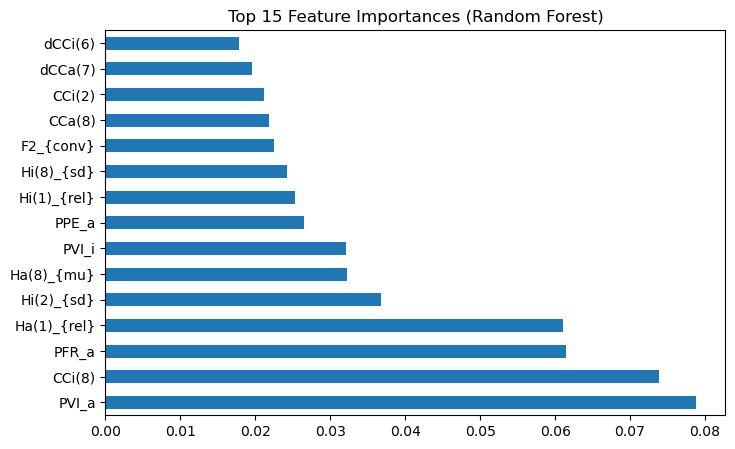

In [2]:
# =========================
# ALS RandomForest Optimization with Optuna + SMOTE
# =========================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from imblearn.over_sampling import SMOTE
import optuna
import warnings
warnings.filterwarnings("ignore")

# =========================
# 1️⃣ Load Dataset
# =========================
data_path = r"D:\ML\Neurodivergent\Minsk2020_ALS_dataset.csv"
data = pd.read_csv(data_path)

print("Dataset shape:", data.shape)
print("Missing values:", data.isnull().sum().sum())

# =========================
# 2️⃣ Data Preprocessing
# =========================

# Assuming last column is target; adjust if needed
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Handle categorical columns if any
X = pd.get_dummies(X, drop_first=True)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# =========================
# 3️⃣ Handle Imbalanced Data with SMOTE
# =========================
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("After SMOTE:", np.bincount(y_train_res))

# =========================
# 4️⃣ Define Optuna Objective Function
# =========================
# =========================
# Updated Optuna Objective Function (Regularized)
# =========================
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 3, 12)
    min_samples_split = trial.suggest_int("min_samples_split", 4, 12)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 8)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2"])
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])
    class_weight = trial.suggest_categorical("class_weight", [None, "balanced"])

    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        class_weight=class_weight,
        random_state=42,
        n_jobs=-1
    )

    score = cross_val_score(rf, X_train, y_train, cv=5, scoring="f1_macro").mean()
    return score


# =========================
# Run Optuna Study
# =========================
print("\nOPTIMIZING HYPERPARAMETERS")
print("="*70)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=60, show_progress_bar=True)

print("\nBest parameters:", study.best_params)
print("Best CV F1 Score:", study.best_value)


# =========================
# 5️⃣ Run Optuna Optimization
# =========================
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\nBest parameters found:")
print(study.best_params)
print("Best F1 Score:", study.best_value)

# =========================
# 6️⃣ Train Final Model with Best Parameters
# =========================
best_params = study.best_params
best_rf = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
best_rf.fit(X_train_res, y_train_res)

# =========================
# 7️⃣ Evaluate Model
# =========================
y_pred_train = best_rf.predict(X_train_res)
y_pred_test = best_rf.predict(X_test)

print("\n--- TRAINING SET ---")
print("Accuracy:", accuracy_score(y_train_res, y_pred_train))
print("F1 Score:", f1_score(y_train_res, y_pred_train))
print("\nClassification Report (Train):\n", classification_report(y_train_res, y_pred_train))

print("\n--- TEST SET ---")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("F1 Score:", f1_score(y_test, y_pred_test))
print("\nClassification Report (Test):\n", classification_report(y_test, y_pred_test))

# =========================
# 8️⃣ Feature Importance (Optional)
# =========================
import matplotlib.pyplot as plt

importances = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=False)[:15]
plt.figure(figsize=(8, 5))
importances.plot(kind="barh")
plt.title("Top 15 Feature Importances (Random Forest)")
plt.show()
